# Time series of temperature gradient

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import LSQUnivariateSpline

datapath1 = '../Processed_data/Nino3_monthly/'
datapath2 = '../Processed_data/WP_monthly/'
experiments = ['piControl', 'historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
models = ['BCC-CSM2-MR', 'CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'MIROC-ES2L', 
          'MIROC6', 'UKESM1-0-LL', 'MRI-ESM2-0',  'CESM2', 'CESM2-WACCM', 'MCM-UA-1-0']

# create dictionary of data for each model, containing only the member we want to use:
data_dict1 = {}; data_dict2 = {};
for model in models:
    data_dict1[model] = {}; data_dict2[model] = {};
    
    file1 = datapath1 + model + '_nino3_monthlyindex.txt'
    file2 = datapath2 + model + '_wp_monthlyindex.txt'
    data_table1 = pd.read_csv(file1, index_col=0, header=[0,1], keep_default_na = False)
    data_table2 = pd.read_csv(file2, index_col=0, header=[0,1], keep_default_na = False)
    if model in ['BCC-CSM2-MR', 'CanESM5', 'MIROC6', 'MRI-ESM2-0',  'CESM2', 'CESM2-WACCM']:
        for exp in experiments:
            member = 'r1i1p1f1'
            data_list1 = data_table1[exp][member].values;
            data_dict1[model][exp] = np.array([np.float(i) for i in data_list1 if i])
            data_list2 = data_table2[exp][member].values;
            data_dict2[model][exp] = np.array([np.float(i) for i in data_list2 if i])
    elif model in ['MIROC-ES2L', 'CNRM-CM6-1','MCM-UA-1-0', 'UKESM1-0-LL']:
        for exp in experiments:
            if exp == 'piControl' and model == 'MCM-UA-1-0':
                member = 'r1i1p1f1'
            else:
                member = 'r1i1p1f2' # I have checked that historical f2 branches from piControl f1 in MCM-UA-1-0.
            if exp in data_table1: # additional if-test here, since 'MCM-UA-1-0' is missing the 'ssp126' experiment
                data_list1 = data_table1[exp][member].values
                data_dict1[model][exp] = np.array([np.float(i) for i in data_list1 if i]) 
                data_list2 = data_table2[exp][member].values
                data_dict2[model][exp] = np.array([np.float(i) for i in data_list2 if i])   
    elif model in ['CNRM-ESM2-1']:
        for exp in experiments:
            if exp == 'piControl':
                member = 'r1i1p1f2'
            else: 
                member = 'r2i1p1f2' # I have checked that historical r2 branches from piControl r1.
            data_list1 = data_table1[exp][member].values
            data_dict1[model][exp] = np.array([np.float(i) for i in data_list1 if i])  
            data_list2 = data_table2[exp][member].values
            data_dict2[model][exp] = np.array([np.float(i) for i in data_list2 if i])

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Find west - east difference between absolute temperatures

In [9]:
def segment_trends_monthly(data, years_used = 500*12, seg_length = 86*12, seg_overlap = 40*12):
    x = data[:years_used]; t = np.arange(len(x))
    # subtract linear trend over all 500 years:
    x = x - np.polyval(np.polyfit(t,x,1),t)
    starttimes = np.arange(0,len(x)-seg_length+1,seg_length - seg_overlap)
    change_list = np.full(len(starttimes), np.nan)

    for (i,k) in enumerate(starttimes):
        segment = x[int(k):int(k)+seg_length]; t = np.arange(len(segment))
        trendpar = np.polyfit(t,segment,1)
        fit = np.polyval(trendpar,t)
        change_list[i] = fit[-1] - fit[0]
    #print(change_list)
    return [np.min(change_list), np.max(change_list)]

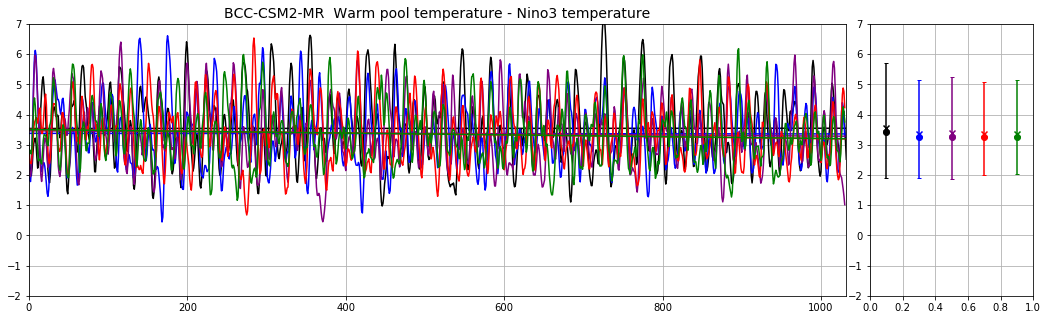

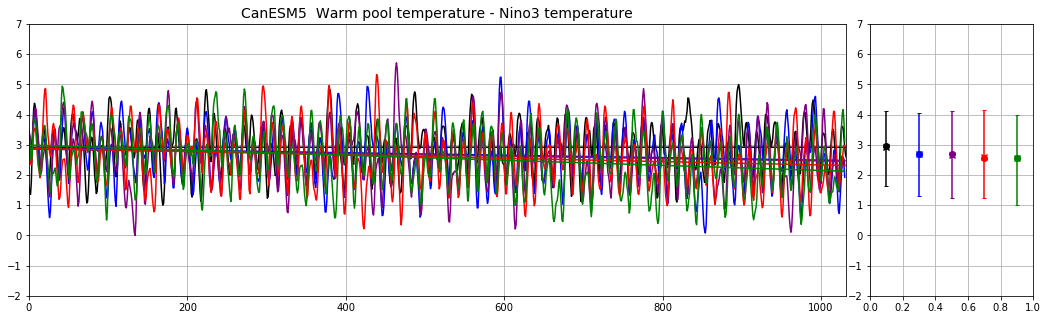

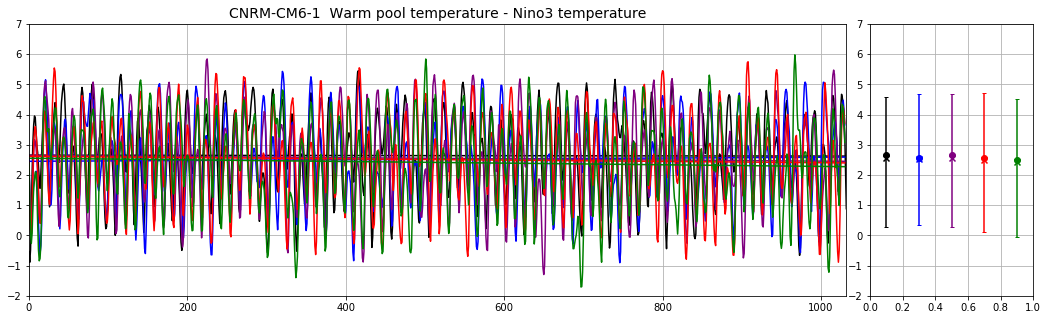

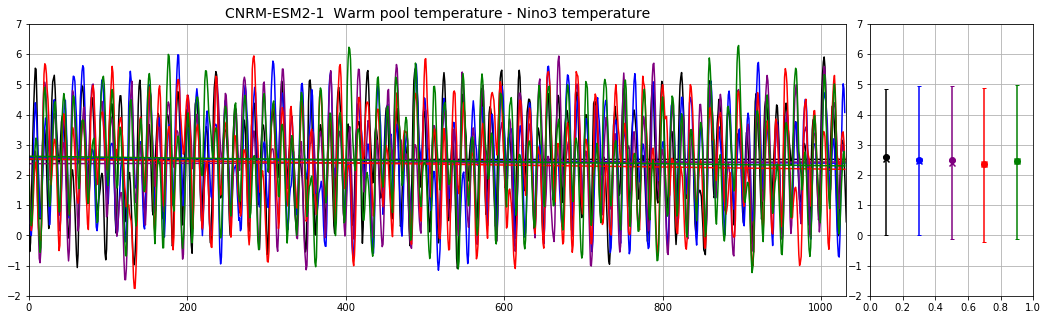

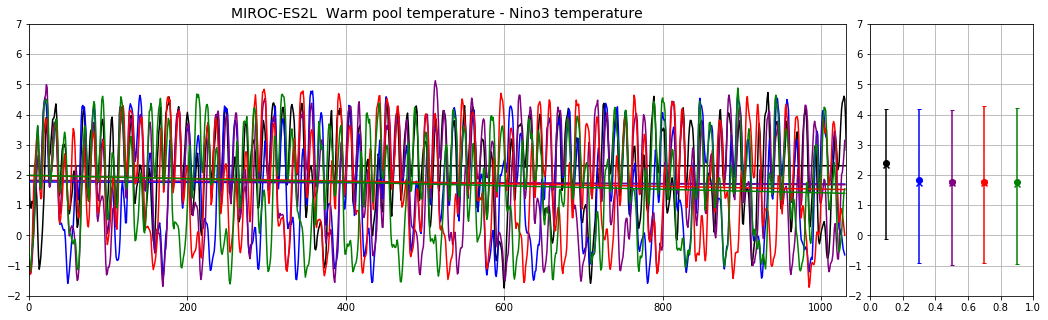

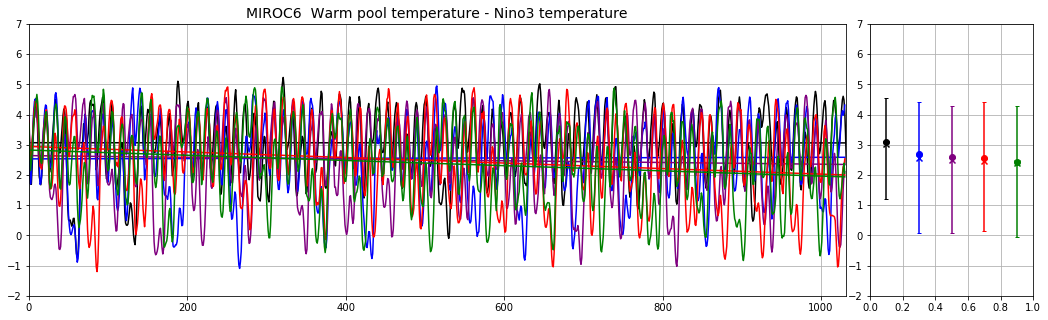

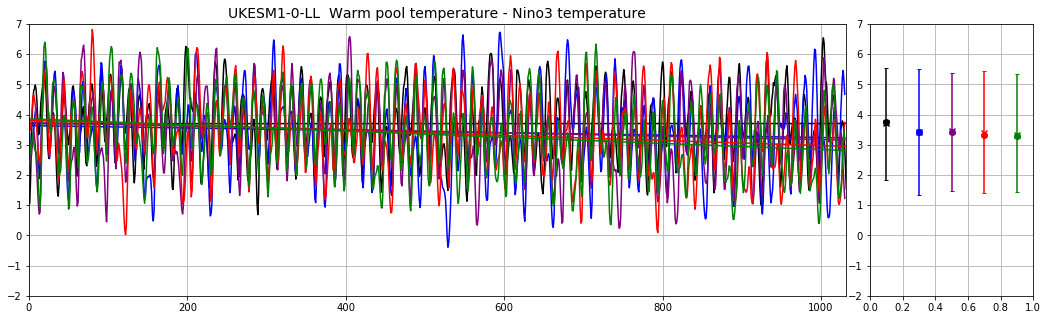

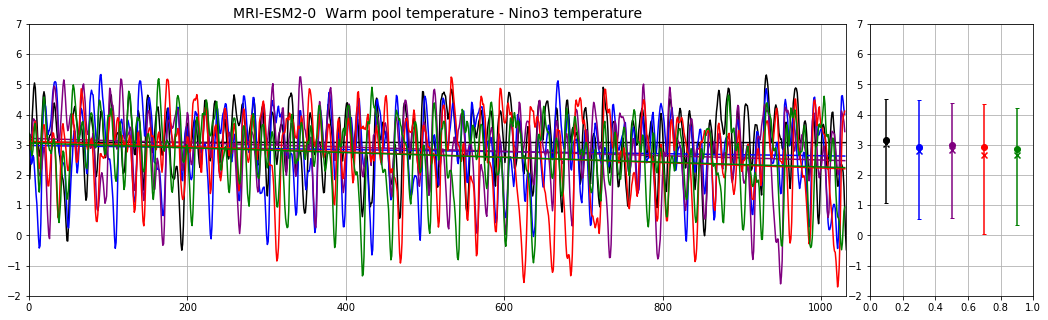

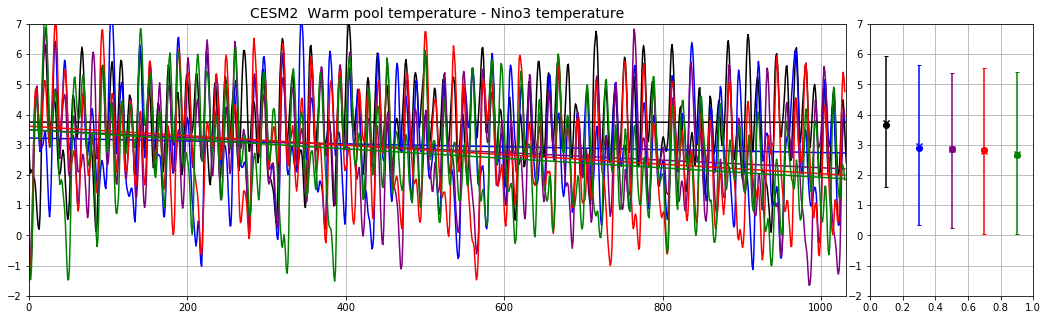

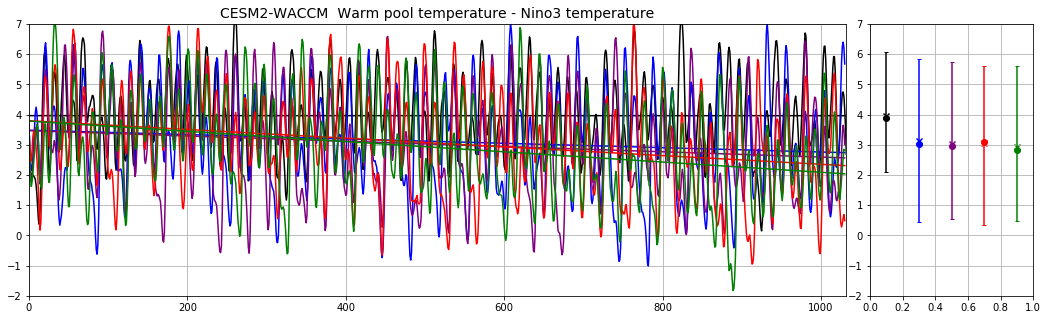

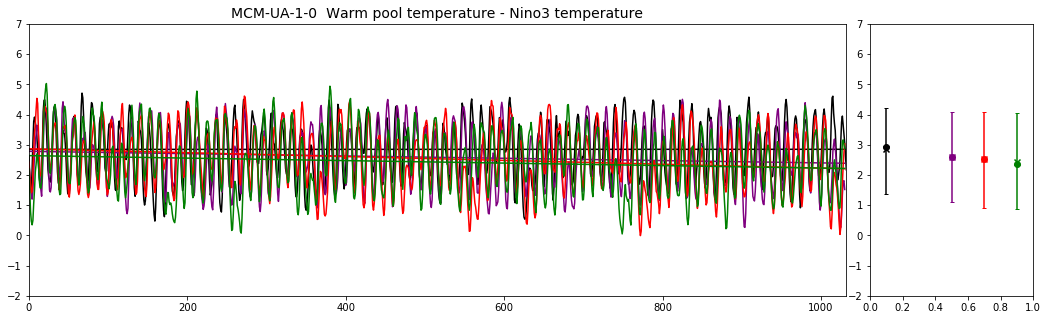

In [37]:
ssp_length = 86*12-1; # cut in year 2100. Some exp go beyond this year.

colors = ['black', 'blue', 'purple', 'red', 'green']
color_dict = {}; xvals = {}
explist = ['piControl', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
for ind,exp in enumerate(explist):
    xvals[exp] = 0.1 + ind*0.2
    color_dict[exp] = colors[ind]
    
gradients = {}
for model in models:
    gradients[model] = {};
    fig, ax = plt.subplots(ncols = 2, figsize = [18,5], gridspec_kw={'width_ratios': [5, 1]})
    plt.subplots_adjust(wspace=0.05)
    for exp in data_dict1[model]:
        data1 = data_dict1[model][exp]; data2 = data_dict2[model][exp]
        gradient = data2 - data1
        if exp in ['ssp126', 'ssp245', 'ssp370', 'ssp585']:
            gradients[model][exp] = gradient[:ssp_length] # west - east
        else:
            gradients[model][exp] = gradient
        if exp in explist:
            y = gradients[model][exp]; t = np.arange(len(y))
            fit = np.polyval(np.polyfit(t,y,1),t)
            ax[0].plot(y, color = color_dict[exp])
            ax[0].plot(t,fit, color = color_dict[exp])
            ax[0].set_xlim(0,ssp_length); ax[0].set_ylim(-2,7)
            ax[0].set_title(model + '  Warm pool temperature - Nino3 temperature', fontsize = 14)
            
            ax[1].scatter(xvals[exp], np.mean(y), marker = 'x', color = color_dict[exp])
            ax[1].errorbar(xvals[exp], np.median(y), yerr = [[np.median(y) - np.percentile(y,5)], [np.percentile(y,95)-np.median(y)]], fmt='o', marker = 'o', color=color_dict[exp], capsize=2)
            ax[1].set_xlim(0,1); ax[1].set_ylim(-2,7)
            ax[0].grid(); ax[1].grid()

## Define anomalies as deviations from piControl climatology

In [2]:
ssp_length = 86*12-1; # cut in year 2100. Some exp go beyond this year.

anomalies1 = {}; anomalies2 = {}

for model in models:
    anomalies1[model] = {}; anomalies2[model] = {}
    exp = 'piControl'
    control_data1 = data_dict1[model][exp]; control_data2 = data_dict2[model][exp]
    # then find piControl climatology:
    c_anom1 = np.concatenate(([np.nan],control_data1,[np.nan]))
    c_anom2 = np.concatenate(([np.nan],control_data2,[np.nan]))
    clim1 = np.zeros(12); clim2 = np.zeros(12);
    for month in range(12):
        clim1[month] = np.nanmean(c_anom1[month::12])
        clim2[month] = np.nanmean(c_anom2[month::12])
    
    anomalies1[model][exp] = control_data1 - np.tile(clim1,int(len(c_anom1)/12))[1:-1]
    anomalies2[model][exp] = control_data2 - np.tile(clim2,int(len(c_anom2)/12))[1:-1]
    
    for exp in experiments[2:]:
        if exp in data_dict1[model]:
            ssp_data1 = data_dict1[model][exp][:ssp_length]; ssp_data2 = data_dict2[model][exp][:ssp_length]
            anomalies1[model][exp] = ssp_data1 - np.tile(clim1,86)[:-1]
            anomalies2[model][exp] = ssp_data2 - np.tile(clim2,86)[:-1]
    

## Compute temperature gradient as difference between anomalies in the nino3 region and the warm pool

In [3]:
gradient = {}
for model in models:
    gradient[model] = {}
    for exp in ['piControl', 'ssp126', 'ssp245', 'ssp370', 'ssp585']:
        if exp in anomalies1[model]:
            gradient[model][exp] = anomalies2[model][exp] - anomalies1[model][exp]

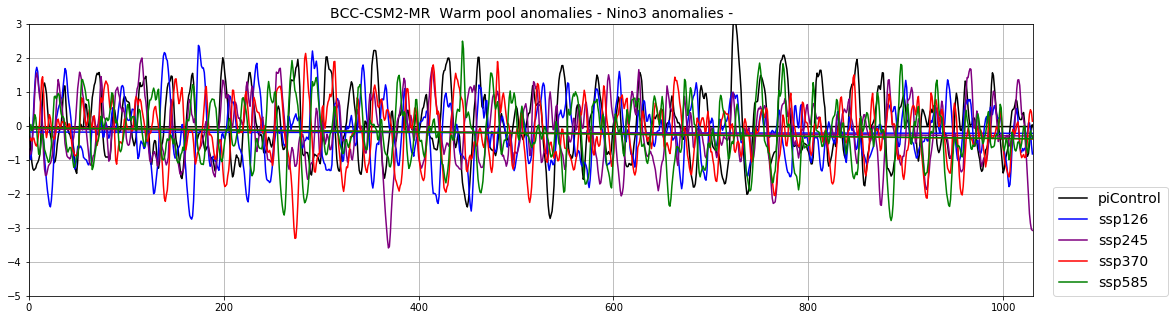

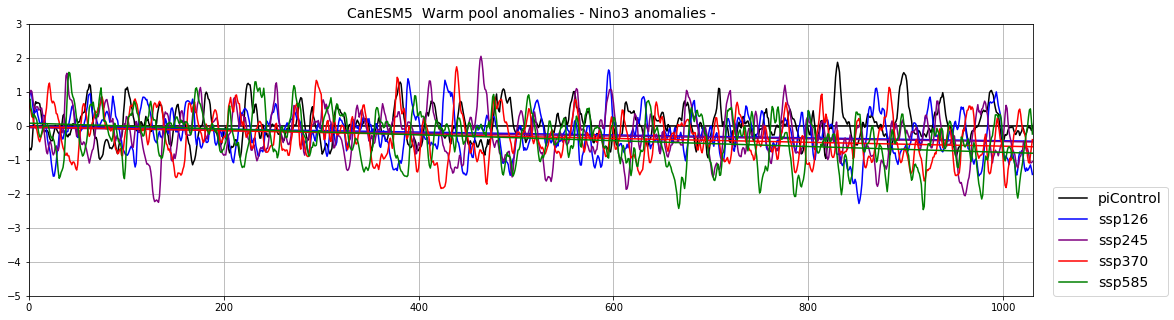

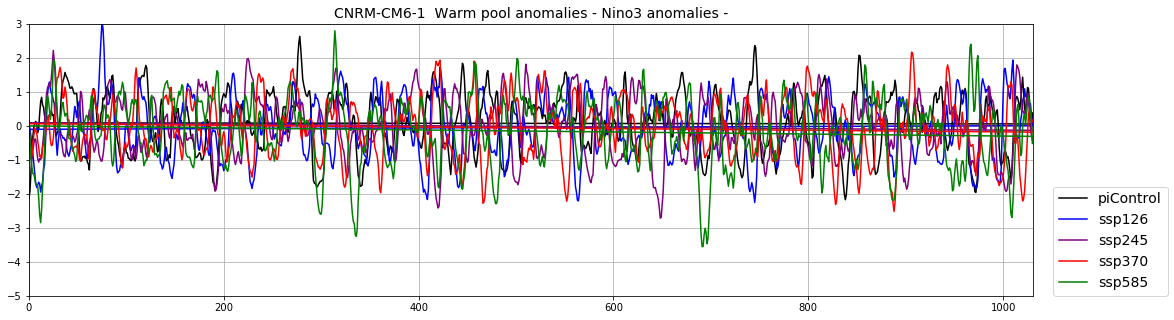

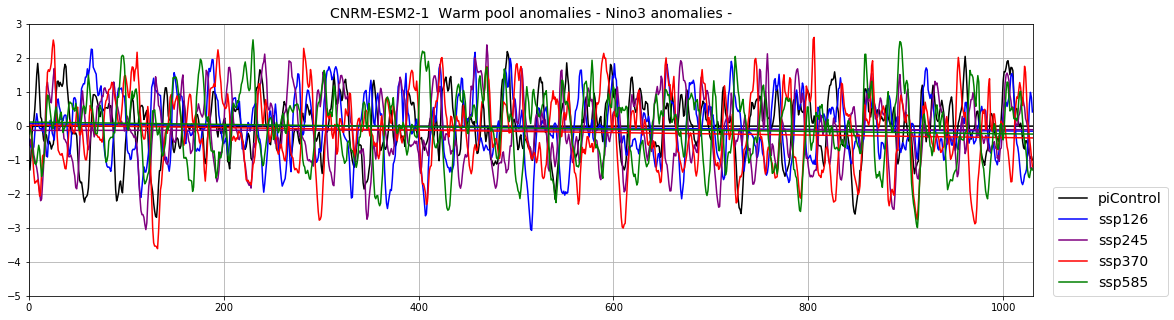

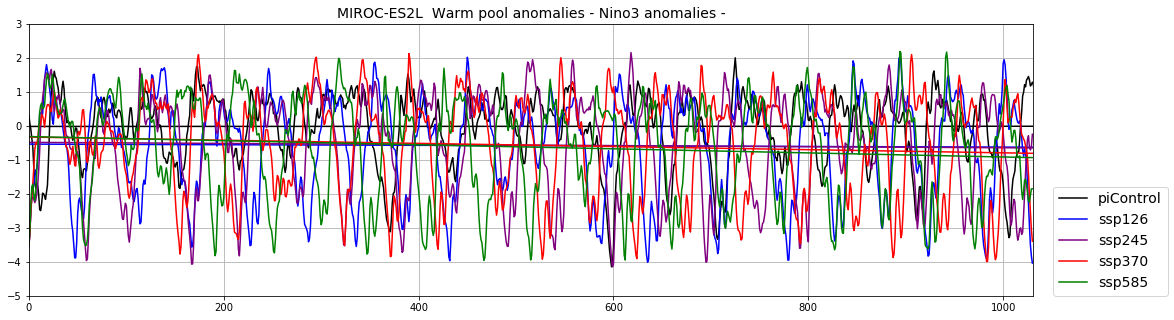

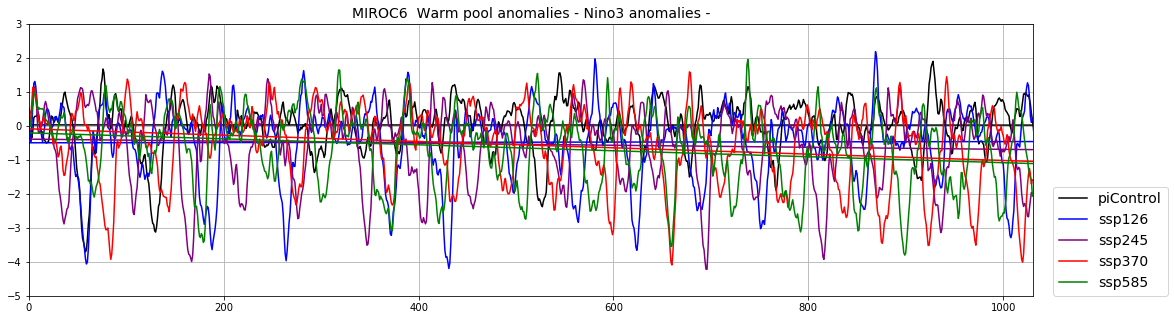

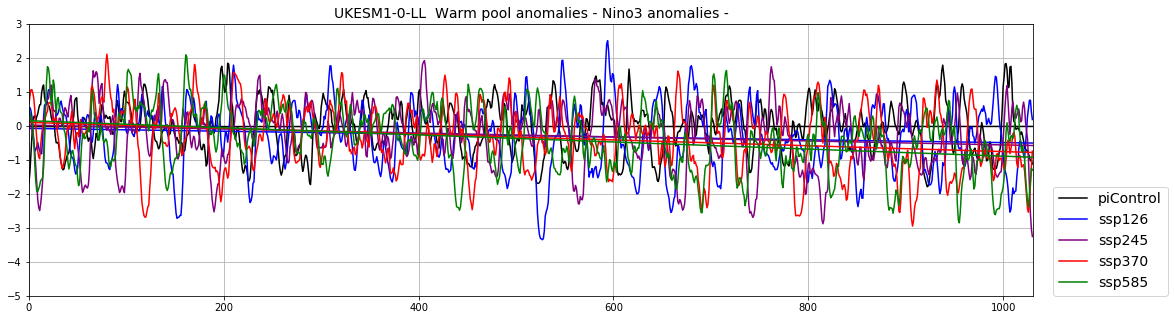

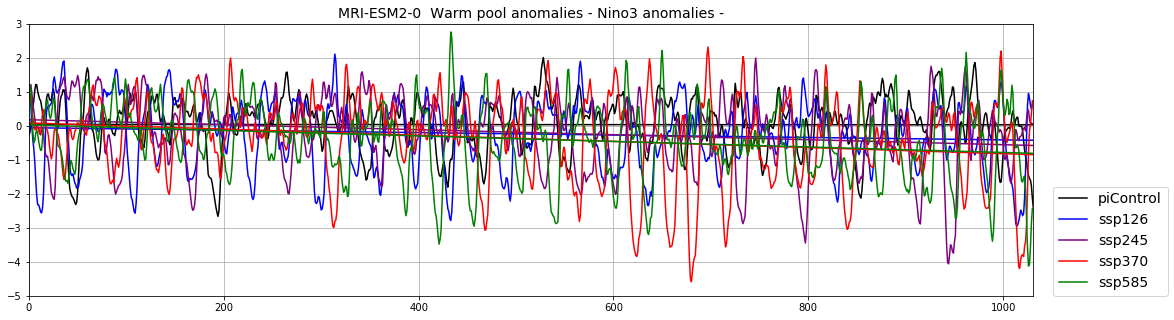

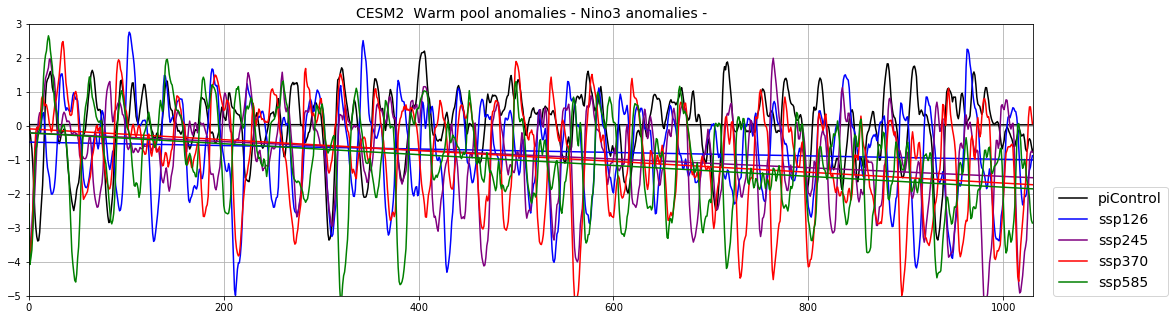

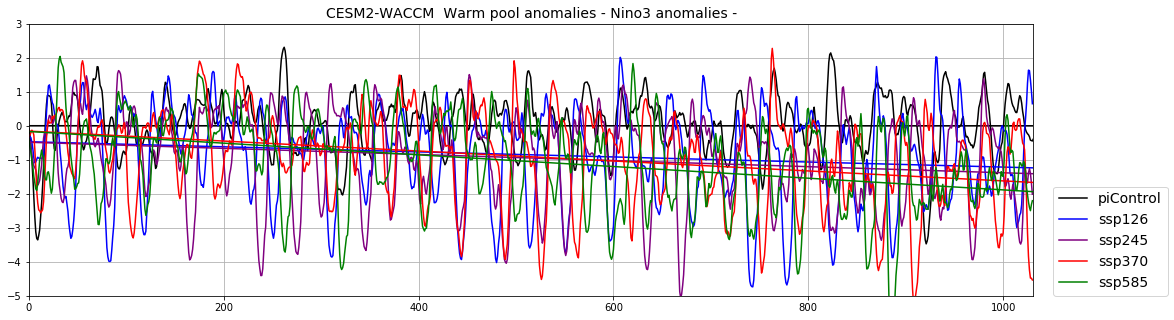

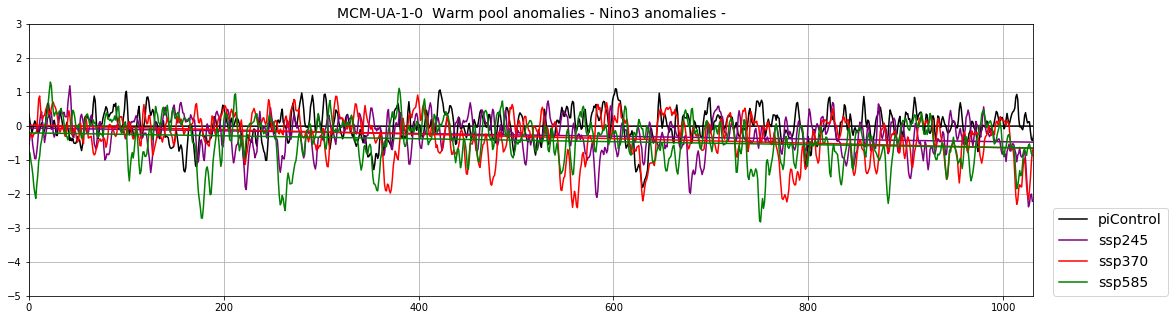

In [6]:
colors = ['black', 'blue', 'purple', 'red', 'green']
color_dict = {}
explist = ['piControl', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
for ind,exp in enumerate(explist):
    color_dict[exp] = colors[ind]

for model in models:
    fig, ax = plt.subplots(figsize = [18,5])
    for exp in gradient[model]:
        y = gradient[model][exp]#[1979:]; 
        t = np.arange(0,len(y))
        ax.plot(t, y, label = exp, color = color_dict[exp])
        
        # fit linear trend
        p = np.polyfit(t,y,1)
        fit = np.polyval(p,t)
        
        ax.plot(t, fit, color = color_dict[exp])
        #ax.plot([0, len(y)], [np.mean(y), np.mean(y)], color = color_dict[exp])
    ax.set_title(model + '  Warm pool anomalies - Nino3 anomalies -', fontsize = 14)
    ax.set_xlim(0,len(y))
    ax.set_ylim(-5,3)
    ax.grid()
    ax.legend(loc=(1.02,0), fontsize = 14)
    

## Some old code:

In [19]:
ssp_length = 86*12-1; # cut in year 2100. Some exp go beyond this year.

gradient_anomalies = {}
for model in models:
    gradient_anomalies[model] = {};
    exp = 'piControl'
    control_data1 = data_dict1[model][exp]; control_data2 = data_dict2[model][exp]
    control_gradient = control_data2 - control_data1 # west - east
    # then find piControl climatology:
    c_grad = np.concatenate(([np.nan],control_gradient,[np.nan]))
    clim = np.zeros(12);
    for month in range(12):
        clim[month] = np.nanmean(c_grad[month::12])
    
    gradient_anomalies[model][exp] = control_gradient #- np.tile(clim,int(len(c_grad)/12))[1:-1] + np.mean(control_gradient)
    
    for exp in experiments[2:]:
        if exp in data_dict1[model]:
            ssp_data1 = data_dict1[model][exp][:ssp_length]; ssp_data2 = data_dict2[model][exp][:ssp_length]
            # approximate missing end of historical by a mean
            exp_data1 = np.concatenate((hist_data1, [np.mean([hist_data1[-1], ssp_data1[0]])], ssp_data1))
            exp_data2 = np.concatenate((hist_data2, [np.mean([hist_data2[-1], ssp_data2[0]])], ssp_data2))
            exp_gradient = exp_data2 - exp_data1
            # subtract seasonal cycle, but not the mean (so we add it again):
            gradient_anomalies[model][exp] = exp_gradient# - np.tile(clim,165+86)[1:-1] + np.mean(exp_gradient)
            
            
            

In [49]:
def segment_trends_monthly(data, years_used = 500*12, seg_length = 86*12, seg_overlap = 40*12):
    x = data[:years_used]; t = np.arange(len(x))
    # subtract linear trend over all 500 years:
    x = x - np.polyval(np.polyfit(t,x,1),t)
    starttimes = np.arange(0,len(x)-seg_length+1,seg_length - seg_overlap)
    change_list = np.full(len(starttimes), np.nan)

    for (i,k) in enumerate(starttimes):
        segment = x[int(k):int(k)+seg_length]; t = np.arange(len(segment))
        trendpar = np.polyfit(t,segment,1)
        fit = np.polyval(trendpar,t)
        change_list[i] = fit[-1] - fit[0]
    #print(change_list)
    return [np.min(change_list), np.max(change_list)]


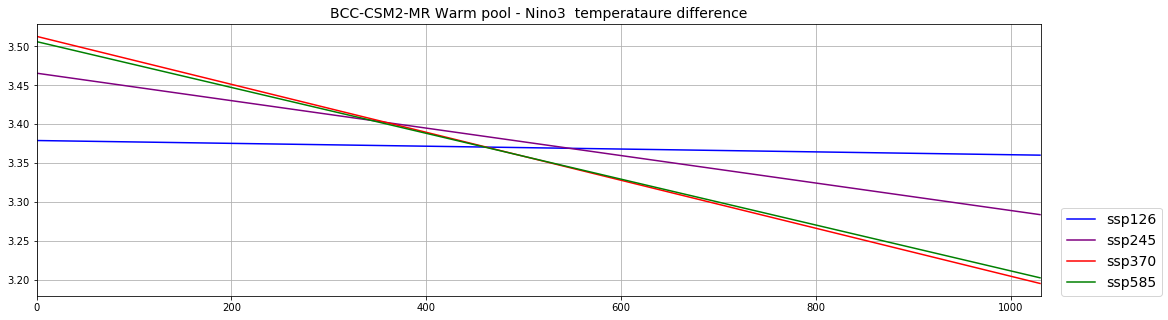

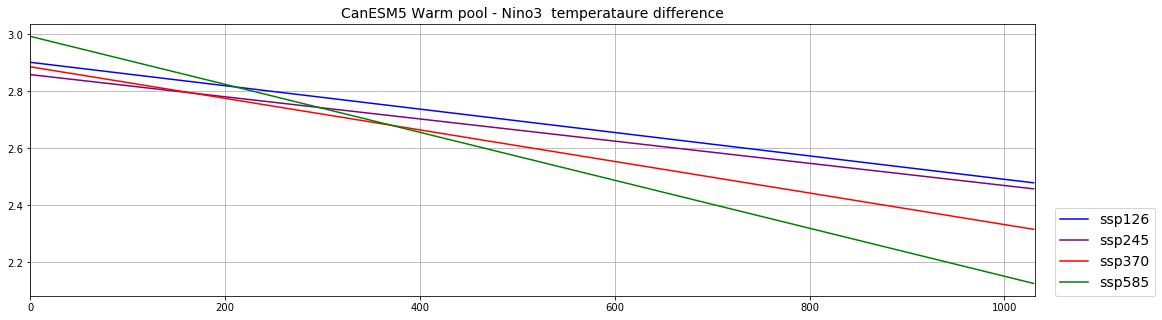

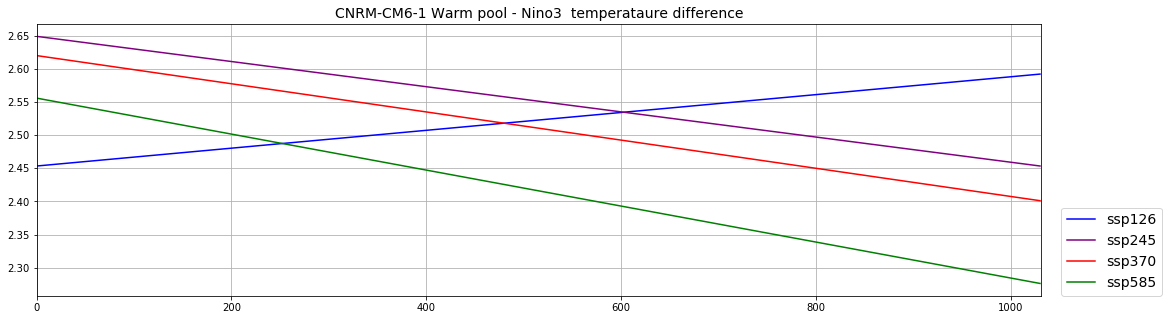

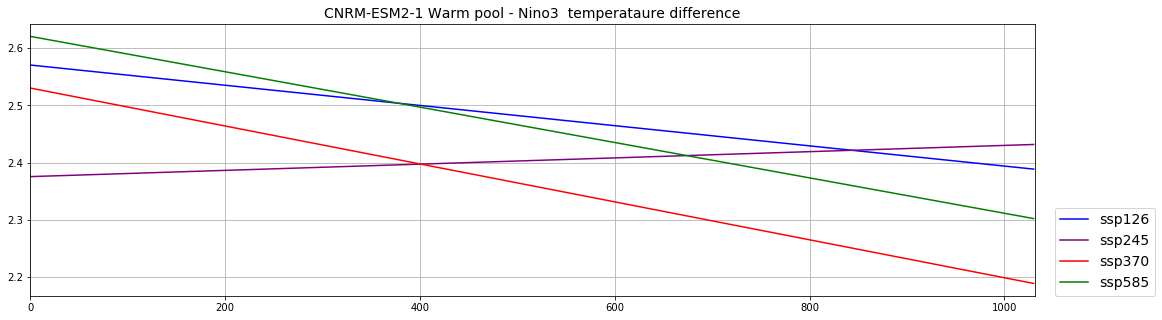

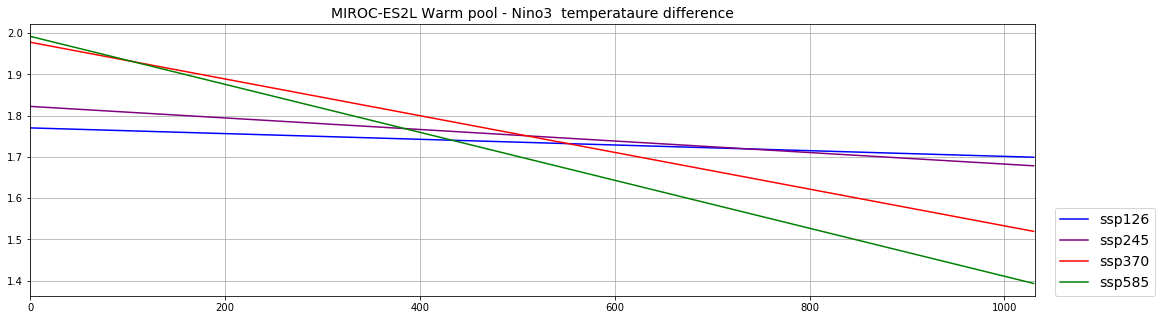

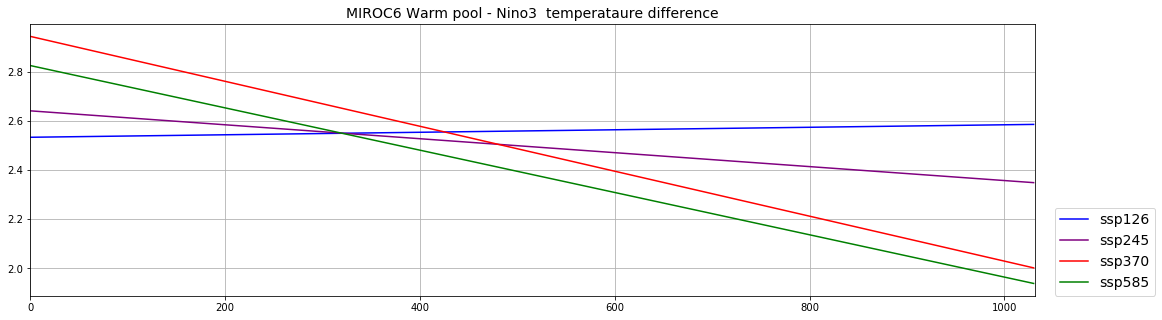

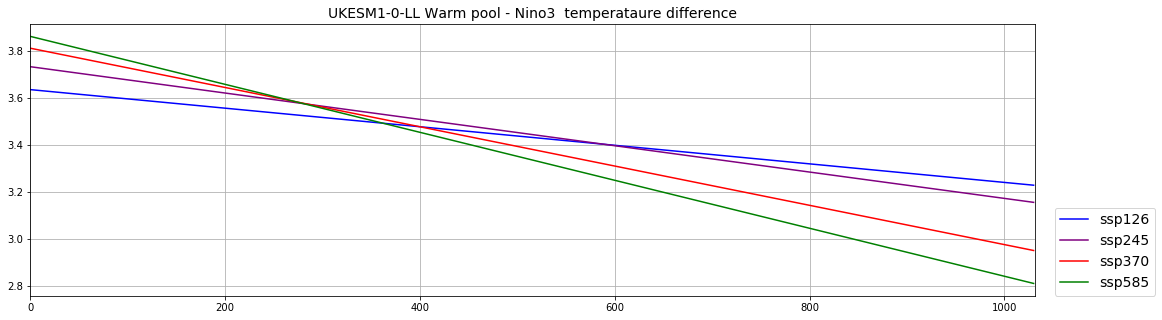

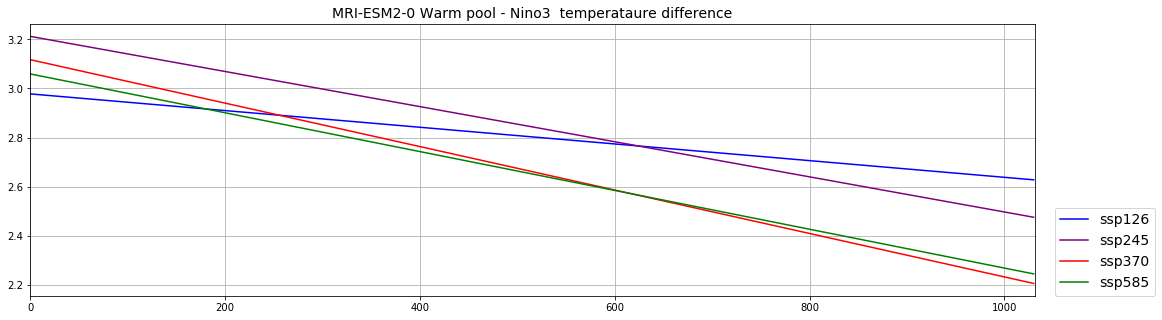

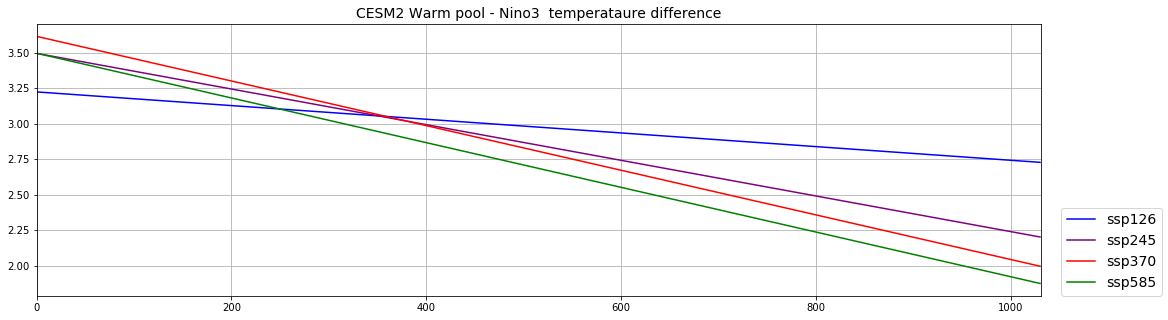

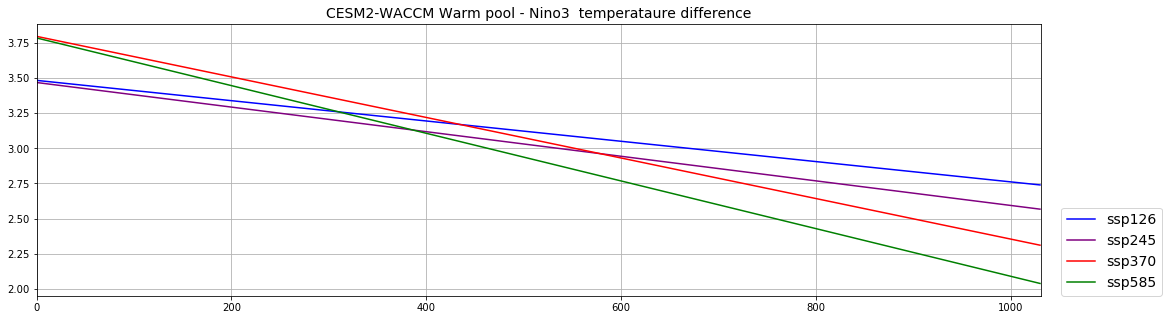

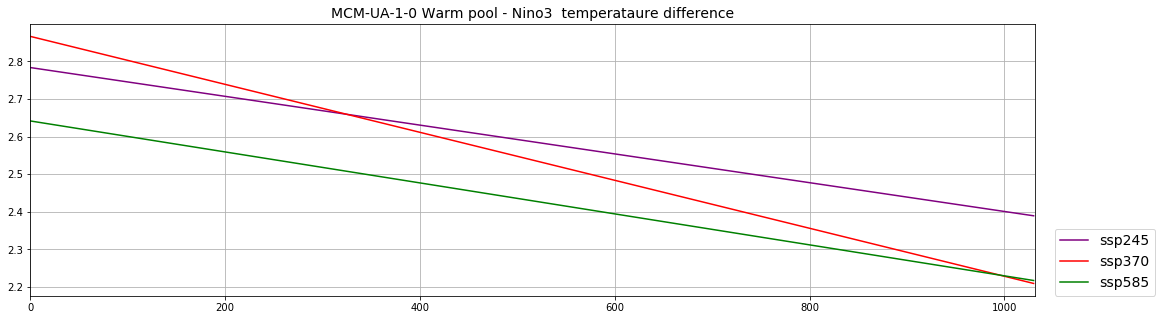

In [50]:
colors = ['black', 'blue', 'purple', 'red', 'green']
color_dict = {}
explist = ['piControl', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
for ind,exp in enumerate(explist):
    color_dict[exp] = colors[ind]

change = {}; control_change = {}
for model in models:
    change[model] = {}; control_change[model] = {}
    fig, ax = plt.subplots(figsize = [18,5])
    for exp in gradient_anomalies[model]:

        if exp == 'piControl':
            y = gradient_anomalies[model][exp]; t = np.arange(0,len(y))
            p = np.polyfit(t,y,1)
            fit = np.polyval(p,t)
            print(fit[-1] - fit[0])
            change[model][exp] = segment_trends_monthly(y)
            #ax.plot(np.arange(len(y)), y, label = exp, color = color_dict[exp])

        else:
            y = gradient_anomalies[model][exp][1979:]; t = np.arange(0,len(y))
            
            # fit linear trend
            p = np.polyfit(t,y,1)
            fit = np.polyval(p,t)
            change[model][exp] = fit[-1] - fit[0]

            ax.plot(t, fit, label = exp, color = color_dict[exp])
    ax.set_title(model + ' Warm pool - Nino3  temperataure difference', fontsize = 14)
    ax.set_xlim(0,len(y))
    #ax.set_ylim(-2,6)
    ax.grid()
    ax.legend(loc=(1.02,0), fontsize = 14)
    